In [54]:
#--------------------------------------------------------
# Comparison of real data with the model
#--------------------------------------------------------

In [763]:
#Libraries
%pylab inline 

from scipy.integrate import solve_ivp
import sdeint
import pickle
import statistics as stat
from scipy import optimize
import matplotlib.mlab as mlab
import scipy.stats as scs
from scipy.optimize import curve_fit
import pandas as pd 

Populating the interactive namespace from numpy and matplotlib


C:\Users\20167990\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['angle', 'e', 'norm', 'f', 'time', 'bincount']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [764]:
df = pd.read_csv('dataframe.csv') #import dataframe

#--------------------------------------------------------------
# Selecting the relevant time interval of the data 
# from: t = '2019-02-25_14:18:31.155622' - index = 1279
# till: t = '2019-02-25_14:19:22.954143' - index = 12805
#--------------------------------------------------------------

df.loc[(df['time']== '2019-02-25_14:18:31.155622')|(df['time']== '2019-02-25_14:19:22.954143')]

df1 = df.drop(range(0,1278))
dat = df1.drop(range(12806,68136))


Text(0.5, 1.0, 'Real data from pedestrians; line crossings')

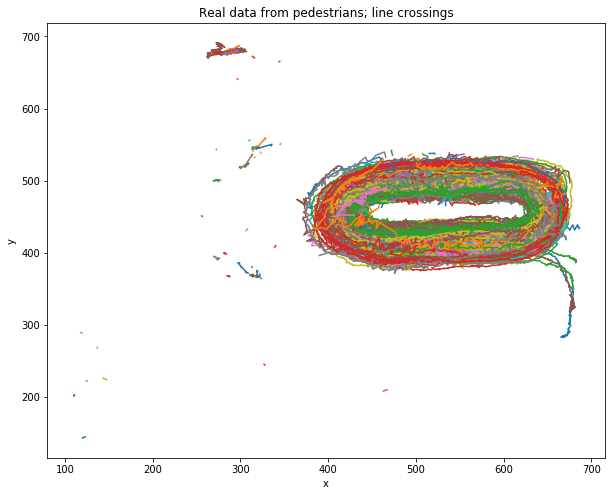

In [765]:
plt.figure(figsize = (10,8))

for i in range(df['particle'].max()): # plotting all the trajectories of the particles
    data1 = df.loc[(df['particle'] == i)]
    plt.plot(data1['x'],data1['y'])
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Real data from pedestrians; line crossings')

#plt.savefig('full_dataset_real_pedestrian.png')

In [766]:
#--------------------------------------------------------------
# Cleaning the dataset from "short" or "empty" trajectories 
#--------------------------------------------------------------
particlelist = []
indexlist = []

for i in range(dat['particle'].max()): 
    clean = dat.loc[dat['particle']== i]
    a = len(clean) # Identifying the particle with few (<250) entries
    if a < 250:
        particlelist.append(i)
    
    c  = clean['x'].max() # Identifying particles with an x > 660
    if c > 670:
        #print(i)
        particlelist.append(i)
    
    d  = clean['y'].min() # Identifying particles with an y < 380
    if d < 380:
        #print(i)
        particlelist.append(i)
        
    e  = clean['x'].min() # Identifying particles with an x < 400
    if e < 400:
        #print(i)
        particlelist.append(i)

    f = clean['y'].min() # Identifying particles with an y > 530
    if f > 530:
        #print(i)
        particlelist.append(i)
        
#print(particlelist)
for i in range(len(particlelist)): # identifying the index numbers
    b = dat.index[dat['particle']== particlelist[i]].tolist()
    indexlist += b

data = dat.drop(indexlist) # Dropping the data from the list

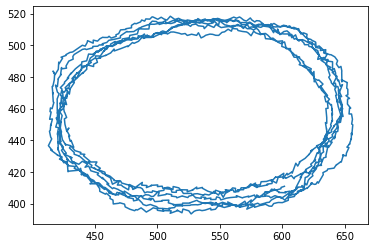

In [767]:
# Example of Trajectory
plt.plot(dat.loc[(dat['particle'] == 0)]['x'],dat.loc[(dat['particle'] == 0)]['y'])

In [768]:
xmid,ymid = [], [] #trying to find the middle of the ellipse

for i in range(data['particle'].max()):
    datai = data.loc[data['particle'] == i]
    yavg = (datai['y'].max() + datai['y'].min())/2
    xavg = (datai['x'].max() + datai['x'].min())/2
    if xavg != 0:
        xmid.append(xavg)
    if yavg != 0:
        ymid.append(yavg)
xmid = [x for x in xmid if (math.isnan(x) == False)]
ymid = [x for x in ymid if (math.isnan(x) == False)]

midpoint = np.array([mean(xmid), mean(ymid)])
print(midpoint)

[533.381122   456.77901401]


536.7848208825071 457.75203817904924


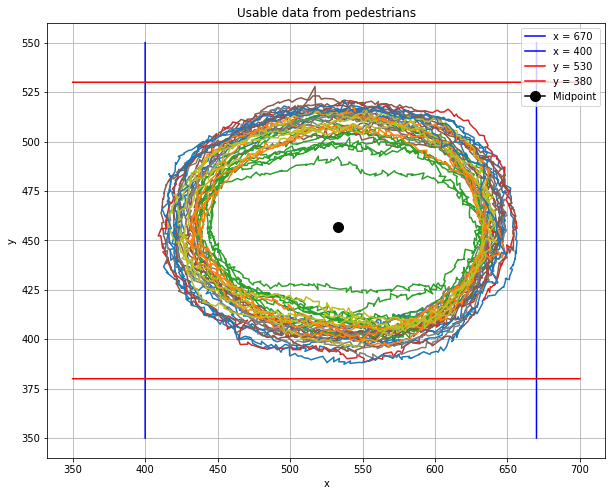

In [769]:
plt.figure(figsize = (10,8)) #Plotting all the useable trajectories in their bounding box

for i in range(data['particle'].max()): # plotting all the trajectories of the particles
    data1 = data.loc[(data['particle'] == i)]
    plt.plot(data1['x'],data1['y'])
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Usable data from pedestrians')

print(data['x'].mean(), data['y'].mean())

yline = linspace(350,550,10000)
xline = linspace(350,700,10000)
plt.plot(670*ones_like(yline),yline, 'b-', label = 'x = 670')
plt.plot(400*ones_like(yline),yline, 'b-', label = 'x = 400')
plt.plot(xline,530*ones_like(xline), 'r-', label = 'y = 530')
plt.plot(xline,380*ones_like(xline), 'r-', label = 'y = 380')

plt.plot(midpoint[0],midpoint[1], marker='o', markersize=10, color="black", label = 'Midpoint')#Plotting the calculated midpoint
plt.legend( loc = 1);
plt.grid(b = True)

plt.savefig('Usable_data_pedestrians.png')

Text(0, 0.5, 'y')

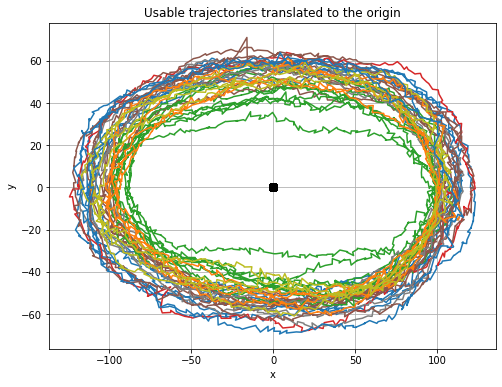

In [770]:
plt.figure(figsize = (8,6)) #Plot of when it its translated to the middle
data['Reduced_x'] = data['x']- midpoint[0] #Translate data to 0,0
data['Reduced_y'] = data['y']- midpoint[1]

for i in range(data['particle'].max()): # Plot data around 0,0
    data1 = data.loc[(data['particle'] == i)]
    plt.plot(data1['Reduced_x'],data1['Reduced_y'])
    plt.plot(0,0, marker = 'o',  markersize=8, color="black", label = '0,0 point')
    
plt.grid(b = True)

plt.title('Usable trajectories translated to the origin')
plt.xlabel('x')
plt.ylabel('y')
#plt.savefig('Usable_trajectories_around_origin.png')

In [771]:
#Calculating the angle and radius from the center for each data entry
angle = round(np.arctan2(data['Reduced_y'],data['Reduced_x']),2)
radius = np.sqrt(np.square(data['Reduced_x'])+np.square(data['Reduced_y']))

data['radius'] = radius
data['angle'] = angle
data.head()

,Unnamed: 0,time,frame,particle,x,x_m,y,yh,v_x,v_x_m,v_y,v_y_m,time_rel,Reduced_x,Reduced_y,radius,angle
1279,2412,2019-02-25_14:18:31.155622,418,0,601.816667,11.658292,410.916667,409.822222,-38.095238,-0.737975,0.000000,0.000000,6.514923,68.435545,-45.862347,82.381907,-0.59
1280,2413,2019-02-25_14:18:31.155622,418,2,434.859375,8.424023,460.312500,460.968085,0.000000,0.000000,38.095238,0.701781,6.514923,-98.521747,3.533486,98.585091,3.11
1281,2414,2019-02-25_14:18:31.155622,418,3,634.363636,12.288787,465.954545,466.117647,-38.095238,-0.737975,-57.142857,-1.052671,6.514923,100.982514,9.175531,101.398514,0.09
1283,2416,2019-02-25_14:18:31.155622,418,5,533.835165,10.341366,403.065934,401.889706,-38.095238,-0.737975,-19.047619,-0.350890,6.514923,0.454043,-53.713080,53.714999,-1.56
1284,2417,2019-02-25_14:18:31.155622,418,12,464.658228,9.001282,418.240506,417.000000,-28.571429,-0.553481,38.095238,0.701781,6.514923,-68.722894,-38.538508,78.791197,-2.63


In [772]:
mean_traj = [] #Calculating the mean radius for each angle
for i in range(int(round(-np.pi,2)*100),int(round(np.pi,2)*100)):
    b = i/100
    a = data.loc[data['angle'] == b]['radius'].mean()
    mean_traj += [[a,b]]

mean_traj = np.array(mean_traj).T.tolist()
shape(mean_traj)

(2, 628)

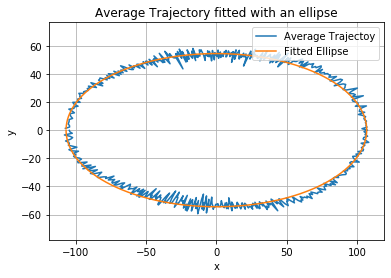

In [773]:
#Trying to fit an ellispe onto the "mean trajectory"

#Defining a fit function

def ellipse(theta, a, b):
    return a*b/(sqrt((b*np.cos(theta))**2+(a*np.sin(theta))**2))

# Getting the data in a single variable

rad = np.array(mean_traj[0])
theta = np.array(mean_traj[1])

# Fit the curve

popt, pcov = curve_fit(ellipse, theta, rad, p0 = [115,49])

plt.figure()

plt.plot(mean_traj[0]*np.cos(mean_traj[1]),mean_traj[0]*np.sin(mean_traj[1])) # Avg traj, in cart plot
plt.plot(ellipse(theta, *popt)*np.cos(theta),ellipse(theta, *popt)*np.sin(theta))#Fitted traj, in cart plot
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Average Trajectory fitted with an ellipse')
plt.grid(b = True)
plt.legend(['Average Trajectoy', 'Fitted Ellipse'], loc = 1)

plt.savefig('Average_trajectory_fitted_with_an_ellipse.png')

In [774]:
semi_axis = popt #calculating properties of the ellipse
eccentricity = np.sqrt(1-(semi_axis[1]**2)/(semi_axis[0]**2))
focal_distance = np.sqrt(semi_axis[0]**2-semi_axis[1]**2)
print(popt,eccentricity, focal_distance)

[106.86970189  54.45896913] 0.8604215834324757 91.95299812256955


In [775]:
mean_velo = mean(np.sqrt(data['v_x_m']**2+data['v_y_m']**2)) #Calculating the mean velocity in m/s and km/h
print(mean_velo, mean_velo*3.6)

1.9014574880563704 6.845246957002933


In [776]:
#---------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------
# Now the data has an average trajectory as well as a fitted ellipse that should be the "white" trajectory
#---------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------

In [777]:
# Using Elliptic Coordinates (m,v)

a = focal_distance #Focal distance used in the definition of the coordinate system

#Defining the Christoffel Symbols
C_mm_m = lambda m,v: 0
C_mv_m = lambda m,v: 0
C_vm_m = lambda m,v: 0
C_vv_m = lambda m,v: 0

C_mm_v = lambda m,v: 0
C_mv_v = lambda m,v: 0
C_vm_v = lambda m,v: 0
C_vv_v = lambda m,v: 0

#-----------------------
# Geodesic Equation
#-----------------------
def rhs_chr(t,s):
    m,v,u,v = s
    
    udot = C_mm_m(m,v) * u**2 + 2 * C_mv_m(m,v) * u * v +  C_vv_m(m,v) * v**2
    vdot = C_mm_v(m,v) * u**2 + 2 * C_mv_v(m,v) * u * v +  C_vv_v(m,v) * v**2
    
    return u,v,-udot,-vdot

#-----------------------
# Passive transport
#-----------------------
def rhs_chr_passive_velocity_transport(t,s):
    m,v,u,v,fmd,fvd = s
    
    uc,vc,udc,vdc = rhs_chr(t,s[:4])
    
    fmd_dot = - ( C_mm_m(m,v) * u*fmd + C_mv_m(m,v) * u * fvd + C_vm_m(m,v) * fmd * v  +  C_vv_m(m,v) * fvd * v )
    fvd_dot = - ( C_mm_v(m,v) * u*fmd + C_mv_v(m,v) * u * fvd + C_vm_v(m,v) * fmd * v  +  C_vv_v(m,v) * fvd * v )
    
        
    return np.array([uc,vc,udc,vdc, fmd_dot, fvd_dot])

#-----------------------
# Active Friction
#-----------------------
tau = 1

def rhs_chr_active_friction(t,s):
    
    uc,vc,udc,vdc, fmd_dot, fvd_dot = rhs_chr_passive_velocity_transport(t,s)
    
    m = s[0]
    v = s[1]
    
    b = fd0
    
    fmd = s[4]
    fvd = s[5]
    normfd = np.sqrt(fmd**2 + fvd**2)
    
    udc += (b*fmd/normfd - uc)/tau #vd/Norm[vd] \alpha
    vdc += (b*fvd/normfd - vc)/tau
    
    return np.array([uc,vc,udc,vdc, fmd_dot, fvd_dot])
    
#------------------------------------
# Confinement
#------------------------------------
alpha = 1
muline = 0.562 #The line around the potential is made
def rhs_confinement(t,s):
    
    m = s[0]
    v = s[1]
    uc,vc,udc,vdc, fmd_dot, fvd_dot = rhs_chr_active_friction(t,s) 
    
    potm = lambda m,v: 2*(m-muline)
    potv = lambda m,v: 0
    
    udc_v = udc - alpha*potm(m,v)
    vdc_v = vdc - alpha*potv(m,v)

    return np.array([uc,vc,udc_v,vdc_v, fmd_dot, fvd_dot])

#------------------------------------
# Noise
#------------------------------------
eps = 0.5

def degen_noise(s,t):
    
    m, v = s[0], s[1]
    B = np.diag([0,0,1,1,0,0]) # diagonal, so independent driving Wiener 
    B[2][2] = -eps*sinh(m)*cos(v)
    B[2][3] = -eps*cosh(m)*sin(v)
    B[3][2] =  eps*cosh(m)*sin(v)
    B[3][3] = -eps*sinh(m)*cos(v)
    
    B = 2/(a*(cos(2*v)-cosh(2*m)))*B
    return B

def no_noise(s,t):
    return 0

swap_arg = lambda f : lambda m,v : f(v,m)

def noise_gen():
    return [no_noise,no_noise,degen_noise,no_noise,no_noise]

def ell_x(m,v):
    return a*np.cosh(m)*np.cos(v)

def ell_y(m,v):
    return a*np.sinh(m)*np.sin(v)

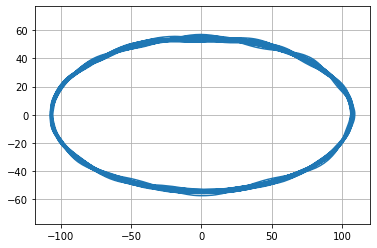

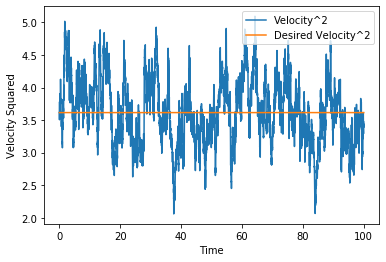

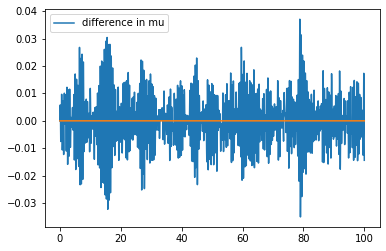

In [778]:
fd0 = mean_velo #making a simulation and plotting the velocity and difference in mu
v_mu = fd0
x0 = np.array([muline, 0e-10, 0, v_mu, 0, v_mu])
eps = 15
alpha = 100

tmax = 100
time  = np.linspace(0, tmax, 100*tmax)

sol = sdeint.itoint(swap_arg(rhs_confinement) #rhs_chr_passive_velocity_transport)
                    ,  degen_noise
                    ,  x0
                    ,  time)

plt.plot(ell_x(sol[:,0],sol[:,1]),ell_y(sol[:,0],sol[:,1]),'-');

nu = linspace(0,np.pi*2,10000)
mu = muline*np.ones_like(nu)
#plt.plot(ell_x(mu,nu), ell_y(mu,nu), label = 'Reference Ellipse')

#plt.plot(mean_traj[0]*np.cos(mean_traj[1]),mean_traj[0]*np.sin(mean_traj[1]), label = 'Average Trajectory') # Avg traj, in cart plot
#plt.plot(ellipse(theta, *popt)*np.cos(theta),ellipse(theta, *popt)*np.sin(theta), label = 'Fitted Trajectory')# Fitted traj, in cart plot
plt.axis('equal')
plt.grid(b = True)

plt.figure()
plt.plot(time,sol[:,2]**2+sol[:,3]**2, label = 'Velocity^2')
#plt.plot(time, mean_velo**2*ones_like(time), label = 'Mean Velocity ^2')
plt.plot(time, sol[:,4]**2+sol[:,5]**2, label = 'Desired Velocity^2')
plt.legend(loc = 1)
plt.xlabel('Time')
plt.ylabel('Velocity Squared')

plt.figure()
diffmu = sol[:,0] - mu
diffnu = sol[:,1] - nu

plt.plot(time,diffmu,label = 'difference in mu')
#plt.plot(time,diffnu,label = 'difference in nu')
plt.plot(time,zeros_like(time))
plt.legend()

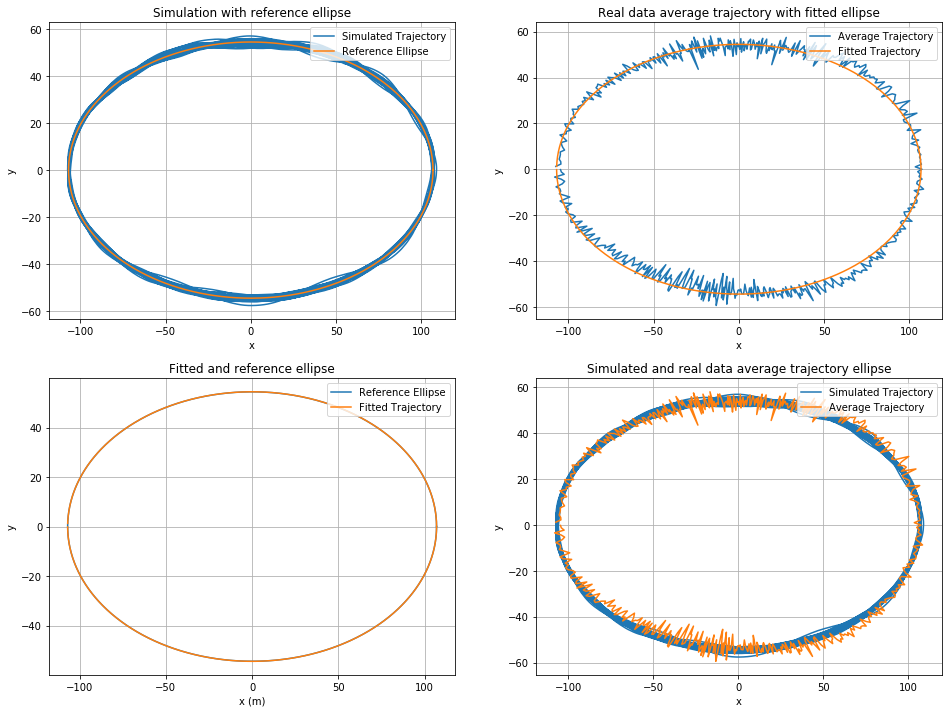

In [779]:
fig, ax = plt.subplots(2,2, figsize = (16,12)) # Making plots for visual comparison of the data and the simulations
ax[0,0].plot(ell_x(sol[:,0],sol[:,1]),ell_y(sol[:,0],sol[:,1]),'-', label = 'Simulated Trajectory');
ax[0,0].plot(ell_x(mu,nu), ell_y(mu,nu), label = 'Reference Ellipse')

ax[0,1].plot(mean_traj[0]*np.cos(mean_traj[1]),mean_traj[0]*np.sin(mean_traj[1]), label = 'Average Trajectory')
ax[0,1].plot(ellipse(theta, *popt)*np.cos(theta),ellipse(theta, *popt)*np.sin(theta), label = 'Fitted Trajectory')

ax[1,0].plot(ell_x(mu,nu), ell_y(mu,nu), label = 'Reference Ellipse')
ax[1,0].plot(ellipse(theta, *popt)*np.cos(theta),ellipse(theta, *popt)*np.sin(theta), label = 'Fitted Trajectory')

ax[1,1].plot(ell_x(sol[:,0],sol[:,1]),ell_y(sol[:,0],sol[:,1]),'-', label = 'Simulated Trajectory');
ax[1,1].plot(mean_traj[0]*np.cos(mean_traj[1]),mean_traj[0]*np.sin(mean_traj[1]), label = 'Average Trajectory')

for i in range(2):
    for j in range(2):
        ax[i,j].grid(b = True)
        ax[i,j].legend(loc = 1)
ax[0,0].set(title = 'Simulation with reference ellipse', xlabel = 'x', ylabel = 'y')
ax[0,1].set(title = 'Real data average trajectory with fitted ellipse', xlabel = 'x', ylabel = 'y' );
ax[1,0].set(title = 'Fitted and reference ellipse', xlabel = 'x (m)', ylabel = 'y')
ax[1,1].set(title = 'Simulated and real data average trajectory ellipse', xlabel = 'x', ylabel = 'y');

plt.savefig('Simulation_and_real_data_compared.png')

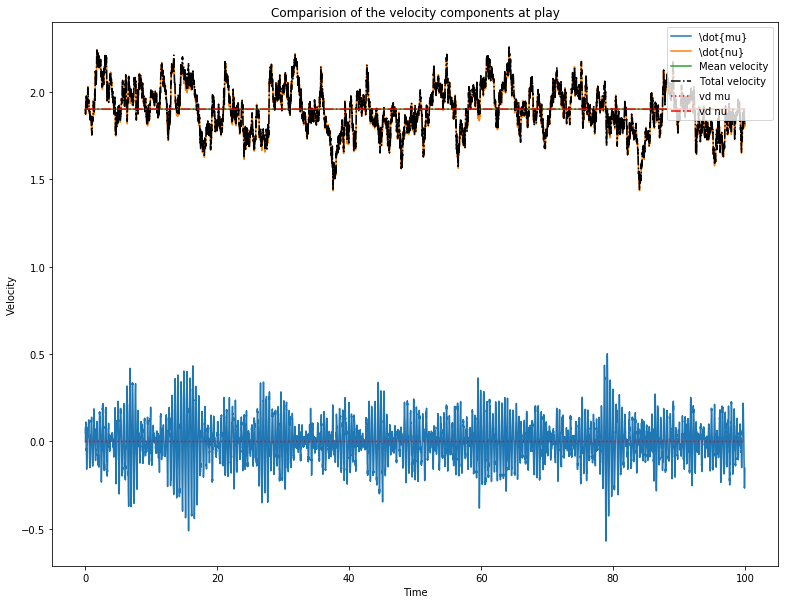

In [783]:
plt.figure(figsize = (13,10)) # Plotting the velocity of the simulations

plt.plot(time,sol[:,2], label = '\dot{mu}')
plt.plot(time,sol[:,3], label = '\dot{nu}')
plt.plot(time, mean_velo*ones_like(time), label = 'Mean velocity')
plt.plot(time, np.sqrt(np.square(sol[:,2])+np.square(sol[:,3])),'k-.', label = 'Total velocity')
plt.plot(time,sol[:,4],'r:', label = 'vd mu')
plt.plot(time,sol[:,5],'r-.', label = 'vd nu')

plt.title('Comparision of the velocity components at play')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend(loc=1)

plt.savefig('Velocity_elliptical_components.png')

In [784]:
#-----------------------------------------------
# Trying to make Histogrmas out of the real data
#-----------------------------------------------

from scipy.optimize import fsolve

In [787]:
x0 = [0.5,0] # Getting mu and nu coordinates from x and y \\\\\ If error execute again
ilist = data.index.values.tolist()
realdata = []

for i in ilist:
    point = [data['Reduced_x'][i],data['Reduced_y'][i]]
    
    def f(x):
        out = [a*np.cosh(x[0])*np.cos(x[1]) - point[0]]
        out.append(a*np.sinh(x[0])*np.sin(x[1]) - point[1])
        return out
    realdata.append(fsolve(f,x0))
    
realdata = np.array(realdata).T.tolist();
realdata[0] = np.abs(realdata[0])

In [788]:
data['mu'] = realdata[0]
data['nu'] = realdata[1]
len(realdata[0])

8659

In [789]:
indexlist = data.index[data['mu'] < 0.23].tolist() #dropping unusable data points
data = data.drop(indexlist)

Text(0.5, 1.0, 'What the data is')

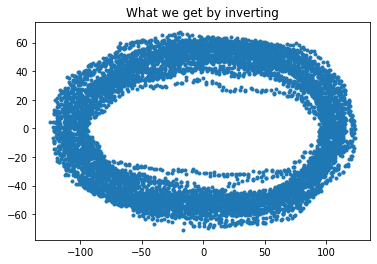

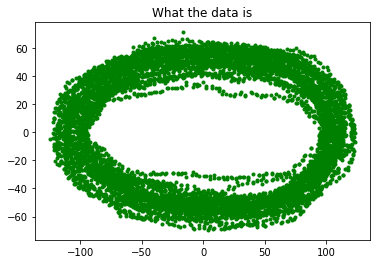

In [790]:
plt.plot(ell_x(data['mu'],data['nu']),ell_y(data['mu'],data['nu']),'o', markersize = 3) #comparing original and result
#plt.xlim(-200,200)
#plt.ylim(-200,500)
plt.title('What we get by inverting')
plt.figure()
plt.plot(data['Reduced_x'],data['Reduced_y'],'og', markersize = 3)
plt.title('What the data is')

In [791]:
indexlist = data.index[data['v_x_m'] < -10].tolist()#dropping unusable data points
data = data.drop(indexlist)
indexlist = data.index[data['v_y_m'] < -10].tolist()
data = data.drop(indexlist)
min(data['v_y_m'])

-3.15801234624709

-0.02893016277370968 1.0755432618855523


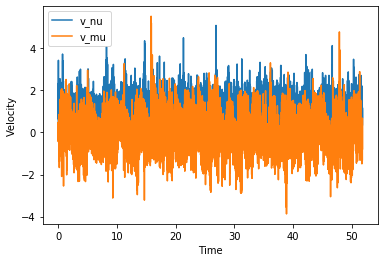

In [792]:
#----------------------------------------------------
# Getting \dot{mu} and \dot{nu} form he real data
#----------------------------------------------------

# Step 1: calculating the Jacobian form the mapping
# Step 2: J_phi {dot} v
Time_axis = linspace(0,max(data['time_rel'])-min(data['time_rel']),len(data['time_rel']))

det_jac1 = a*np.sqrt((np.sinh(data['mu'])**2+np.sin(data['nu'])**2))/(np.cosh(data['mu'])**2*np.sin(data['nu'])**2-np.sinh(data['mu'])**2*np.cos(data['nu'])**2)
det_jac = 1/(cos(2*data['nu'])-cosh(data['mu']*2))
#det_jac = 1

data['v_mu'] =         2*np.sinh(data['mu'])*np.cos(data['nu'])*data['v_x_m']*det_jac - 2*np.cosh(data['mu'])*np.sin(data['nu'])*data['v_y_m']*det_jac
data['v_nu'] = np.abs( 2*np.cosh(data['mu'])*np.sin(data['nu'])*data['v_x_m']*det_jac + 2*np.sinh(data['mu'])*np.cos(data['nu'])*data['v_y_m']*det_jac)

#data['v_mu'] = det_jac*np.cosh(data['mu'])*np.sinh(data['mu'])*(sin(data['nu'])**2-cos(data['nu']))
#data['v_nu'] = det_jac*sin(data['nu'])*cos(data['nu'])

plt.plot(Time_axis,data['v_nu'],label = 'v_nu')
plt.plot(Time_axis,data['v_mu'],label = 'v_mu')
plt.legend()
#plt.ylim(-5,5)
plt.xlabel('Time')
plt.ylabel('Velocity')
#plt.plot(np.sqrt(v_mu**2+v_nu**2))
print(mean(data['v_mu']),mean(data['v_nu']))

#plt.figure()
#plt.hist(data['v_x_m'], bins = 20)
#plt.figure()
#plt.hist(data['v_y_m'], bins = 20);

Text(0.5, 1.0, 'Comparison of a real, simulated and white trajectory')

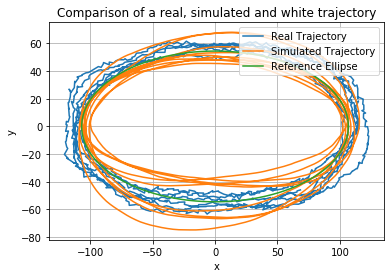

In [826]:
fd0 = mean(data['v_nu']) #Plotting a single trajectory, simulated trajectory and the reference ellipse
v_mu = fd0
x0 = np.array([muline, 0e-10, 0, v_mu, 0, v_mu])
eps = 13
alpha = 0.8
tau = 1
i  = 0 #Particle number

tmax = 10
particle_0 = data.loc[data['particle']==i]
time  = np.linspace(0, max(particle_0['time_rel'])-min(particle_0['time_rel']),len(particle_0['time_rel']))


sol = sdeint.itoint(swap_arg(rhs_confinement) #rhs_chr_passive_velocity_transport)
                    ,  degen_noise
                    ,  x0
                    ,  time)

plt.plot(data.loc[(data['particle'] == i)]['Reduced_x'],data.loc[(data['particle'] == i)]['Reduced_y'],label = 'Real Trajectory' )
plt.plot(ell_x(sol[:,0],sol[:,1]),ell_y(sol[:,0],sol[:,1]),'-', label = 'Simulated Trajectory');
plt.plot(ell_x(mu,nu), ell_y(mu,nu), label = 'Reference Ellipse')
plt.grid(b=True)
plt.legend(loc=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of a real, simulated and white trajectory')
#plt.savefig('Trajectory_comparison.png')


In [827]:
from scipy.stats import norm

In [828]:
#-----------------------------------------------------
# Solving for "Samplesize" trajectories
#-----------------------------------------------------

samplesize = 500
fd0 = mean(data['v_nu'])
v_mu = fd0
muline = 0.576 #mean(data['mu'])
x0 = np.array([muline, 0e-10, 0, v_mu, 0, v_mu])
eps = 18.5#9.337
alpha = 18# 16.05
tau = 4.4#10.2

tmax = 10
time  = np.linspace(0, 51, 628)

simu = []

#for i in range(0,samplesize):
    #sol = sdeint.itoint(swap_arg(rhs_confinement) #rhs_chr_passive_velocity_transport)
                    #,  degen_noise
                    #,  x0
                    #,  time)
    #simu.append(sol)
    #if i%50 == 0:
        #print(i)
    
simu = pickle.load(open('Elliptical_simulations.dat','rb'))
shape(simu)

(500, 628, 6)

In [829]:
data_pre = [] #Taking data in after transient time and makig one list of it
for i in range(0,samplesize):
    data_pre.extend(simu[i][100:628])
simudata = np.array(data_pre).T.tolist()
mean(data['mu'])

0.5622554931735623

In [830]:
import scipy.stats

[-56.66583507  65.35221261  -9.61701763]
[-3.81897838e-03  2.59684633e-01  4.69613465e+00]


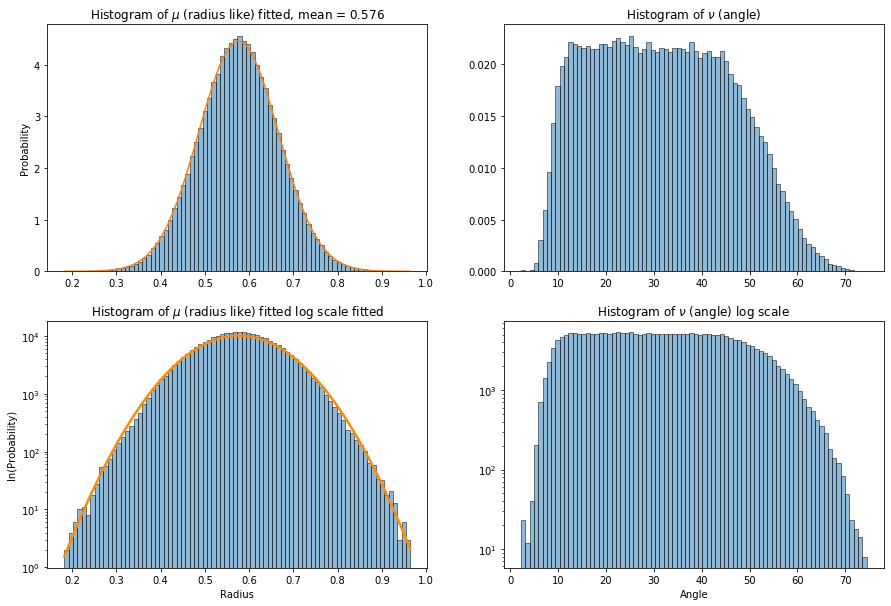

In [831]:
#Making and fitting histograms
elldata = simudata
#elldata = [data['mu'],data['nu'],data['v_mu'],data['v_nu']]

#---------------------------------------
# Fitting Parabola on the histogram
#---------------------------------------\
fig, ax = plt.subplots(2, 2, figsize=(15,10))

bincount = 80

for i in range(2):

    n, bins, _ = ax[0,i].hist(elldata[i], bincount,density=1, alpha=0.5,edgecolor='black')

    mu, sigma = scipy.stats.norm.fit(elldata[i])

    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    
    if i == 0:
        ax[0,0].plot(bins, best_fit_line)
#--------------------------------------------------------------

# 1.) Necessary imports. 

# 2.) Define fit function.
def fit_function(x, a, b, c):
    return (a * x**2 + b*x + c)

# 1.) Necessary imports. 

# 2.) Define fit function.
def fit_function(x, a, b, c):
    return (a * x**2 + b*x + c)

for i in range(2):
    # 3.) Generate the histograms.
    bins = np.linspace(min(elldata[i]), max(elldata[i]), bincount)
    data_entries, bins = np.histogram(elldata[i], bins= bincount)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

    # 4.) Fit the function to the histogram data.
    with errstate(divide='ignore'):
        data_entries_new = [i if i != 0 else 1 for i in data_entries]
        ydat = np.log(data_entries_new)
    popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=ydat, p0=[1, 1, 1,])
    print(popt)

    # 5.) Generate enough x values to make the curves look smooth.
    xspace = np.linspace(min(elldata[i]), max(elldata[i]), 100000)

    # Plot the histogram and the fitted function.
    ax[1,i].hist(elldata[i],bins = bincount, label=r'Histogram entries', log='True',edgecolor='black', alpha=0.5)
    if i == 0:
        ax[1,i].plot(xspace, np.exp(fit_function(xspace, *popt)), color='darkorange', linewidth=2.5, label='Fitted function');
    
    
    
ax[0, 0].set_title(r'Histogram of $\mu$ (radius like) fitted, mean = %.3f'%(mean(elldata[0])))
ax[0, 0].set(ylabel = 'Probability')

ax[0, 1].set_title(r'Histogram of $\nu$ (angle)')
    
ax[1, 0].set_title(r'Histogram of $\mu$ (radius like) fitted log scale fitted')
ax[1, 0].set(ylabel = r'ln(Probability)', xlabel = 'Radius')
   
ax[1, 1].set_title(r'Histogram of $\nu$ (angle) log scale')
                   
ax[1, 1].set(xlabel = r'Angle');

#fig.savefig('Elliptical_simulations_histograms_position.png')
#fig.savefig('Real_data_histograms_position.png')

[-1.57238153  0.03512747  9.93219022]
[-3.55655811  7.35154259  6.05080383]


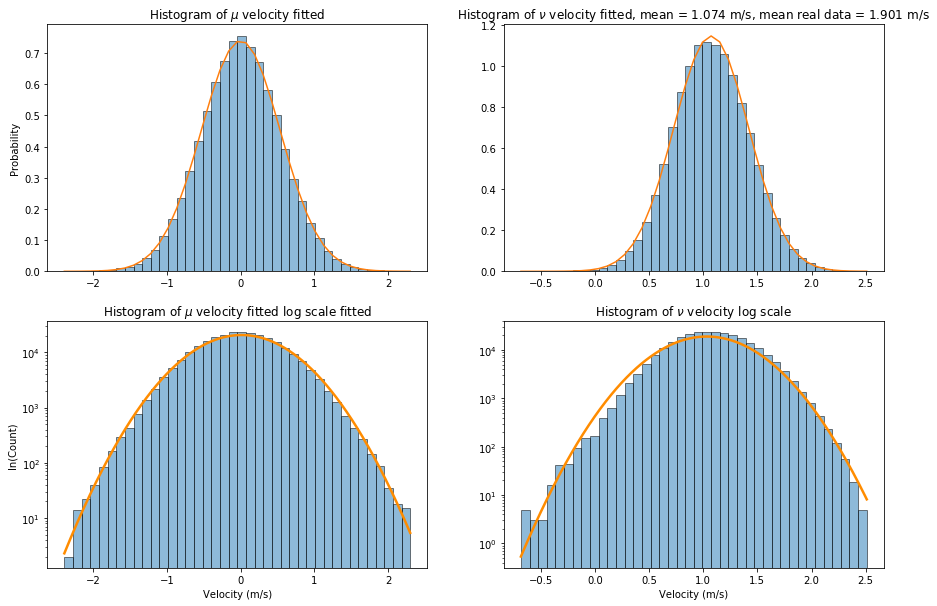

In [832]:
elldata = simudata
#elldata = [data['mu'],data['nu'],data['v_mu'],data['v_nu']]
#---------------------------------------
# Fitting Parabola on the histogram
#---------------------------------------\
fig, ax = plt.subplots(2, 2, figsize=(15,10))

bincount = 40

for i in range(2):

    n, bins, _ = ax[0,i].hist(elldata[i+2], bincount,density=1, alpha=0.5,edgecolor='black')

    mu, sigma = scipy.stats.norm.fit(elldata[i+2])

    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    
    ax[0,i].plot(bins, best_fit_line)
#--------------------------------------------------------------

# 1.) Necessary imports. 

# 2.) Define fit function.
def fit_function(x, a, b, c):
    return (a * x**2 + b*x + c)

# 1.) Necessary imports. 

# 2.) Define fit function.
def fit_function(x, a, b, c):
    return (a * x**2 + b*x + c)

for i in range(2):
    # 3.) Generate the histograms.
    bins = np.linspace(min(elldata[i+2]), max(elldata[i+2]), bincount)
    data_entries, bins = np.histogram(elldata[i+2], bins= bincount)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

    # 4.) Fit the function to the histogram data.
    with errstate(divide='ignore'):
        data_entries_new = [i if i != 0 else 1 for i in data_entries]
        ydat = np.log(data_entries_new)
    popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=ydat, p0=[1, 1, 1,])
    print(popt)

    # 5.) Generate enough x values to make the curves look smooth.
    xspace = np.linspace(min(elldata[i+2]), max(elldata[i+2]), 100000)

    # Plot the histogram and the fitted function.
    ax[1,i].hist(elldata[i+2],bins = bincount, label=r'Histogram entries', log='True',edgecolor='black', alpha=0.5)
    ax[1,i].plot(xspace, np.exp(fit_function(xspace, *popt)), color='darkorange', linewidth=2.5, label='Fitted function');
    
    
    
ax[0, 0].set_title(r'Histogram of $\mu$ velocity fitted')
ax[0, 0].set(ylabel = 'Probability')

ax[0, 1].set_title(r'Histogram of $\nu$ velocity fitted, mean = %.3f m/s, mean real data = %.3f m/s' %(mean(elldata[3]),mean_velo))
    
ax[1, 0].set_title(r'Histogram of $\mu$ velocity fitted log scale fitted')
ax[1, 0].set(ylabel = r'ln(Count)', xlabel = 'Velocity (m/s)')
   
ax[1, 1].set_title(r'Histogram of $\nu$ velocity log scale')
                   
ax[1, 1].set(xlabel = r'Velocity (m/s)');

#fig.savefig('Real_Data_histograms_velocity.png')

In [834]:
import seaborn as sns

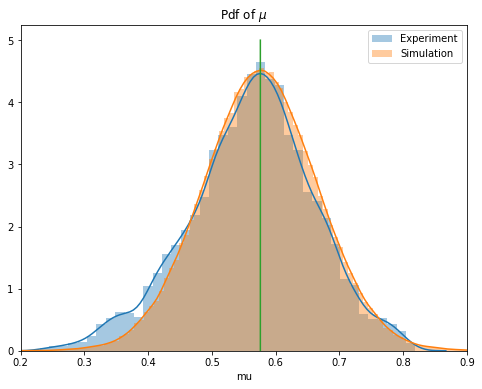

In [835]:
plt.figure(figsize = (8,6) )
sns.distplot(data['mu'] , bins = 40, hist = 1, norm_hist = True, label = 'Experiment')
sns.distplot(simudata[0], bins = 100, hist = 1, norm_hist = True, label = 'Simulation')
plt.legend()
plt.title(r'Pdf of $\mu$')
plt.xlim(0.2,0.9)
median(data['mu'])
plt.plot(0.576*ones_like(linspace(0,5,10000)),linspace(0,5,10000))

Text(0.5, 1.0, 'Pdf of $\\dot{\\mu}$')

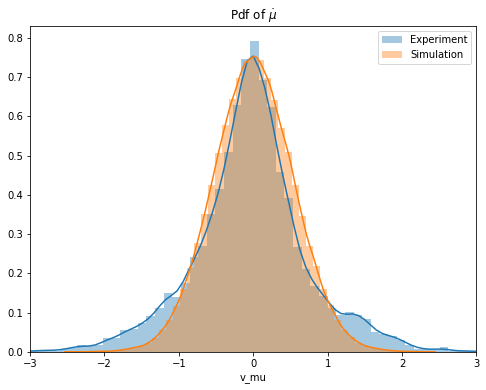

In [836]:
plt.figure(figsize=(8,6))
sns.distplot(data['v_mu'] , bins =81, kde = True, label = 'Experiment')
sns.distplot(simudata[2], kde = True, label = 'Simulation')
plt.xlim(-3,3)
plt.legend()
plt.title(r'Pdf of $\dot{\mu}$')